## Import

In [1]:
#@title Import modules
import os
import copy
import pickle
import secrets
import statistics
from time import time
import tqdm
os.environ['USE_FLASH_ATTENTION'] = '1'
import torch
torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_cudnn_sdp(True)
import TMIDIX
from midi_to_colab_audio import midi_to_colab_audio
from x_transformer_1_23_2 import *
import random
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn import metrics
from IPython.display import Audio, display
from huggingface_hub import hf_hub_download

import cv2
from my_utils import *

## Load Model

In [3]:
import os
os.environ["HF_ENDPOINT"] ="https://hf-mirror.com" 
os.environ["all_proxy"]="127.0.0.1:7890"
from huggingface_hub import notebook_login
notebook_login()

In [2]:
#@title Load Giant Music Transformer Pre-Trained Model
select_model_to_load = "482M-8L-Ultra-Fast-Medium" 
# @param ["482M-8L-Ultra-Fast-Medium","585M-32L-Very-Fast-Large","786M-44L-Fast-Extra-Large"]
model_precision = "bfloat16" # @param ["bfloat16", "float16"]
plot_tokens_embeddings = "None" 
full_path_to_models_dir = "./content/Giant-Music-Transformer/Models"

model_path, mdim, num_layers, mrpe = get_model_path(select_model_to_load, full_path_to_models_dir)

device_type = 'cuda'
if model_precision == 'bfloat16' and torch.cuda.is_bf16_supported():
  dtype = 'bfloat16'
else:
  dtype = 'float16'

if model_precision == 'float16':
  dtype = 'float16'
ptdtype = {'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype)
SEQ_LEN = 8192
PAD_IDX = 19463
model = TransformerWrapper(
        num_tokens = PAD_IDX+1,
        max_seq_len = SEQ_LEN,
        attn_layers = Decoder(dim = mdim,
                              depth = num_layers,
                              heads = 32,
                              rotary_pos_emb = mrpe,
                              attn_flash = True
                              )
)

model = AutoregressiveWrapper(model, ignore_index=PAD_IDX, pad_value=PAD_IDX)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()
print('Model summary...')
# summary(model)

Model already exists...
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/tmp/ipykernel_2943463/3807802412.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model summary...


## (LOAD SEED MIDI)

Loading seed MIDI...
Composition stats:
Composition has 72 notes
Composition has 216 tokens
Composition MIDI patches: [0]


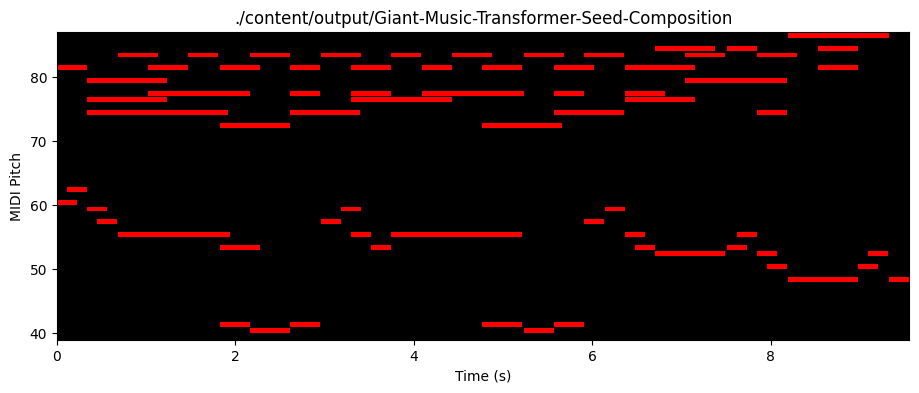

In [5]:
#@title Load Seed MIDI
select_seed_MIDI = "midi_0" 
# @param ["Upload your own custom MIDI", "Giant-Music-Transformer-Piano-Seed-1", "Giant-Music-Transformer-Piano-Seed-2", "Giant-Music-Transformer-Piano-Seed-3", "Giant-Music-Transformer-Piano-Seed-4", "Giant-Music-Transformer-Piano-Seed-5", "Giant-Music-Transformer-Piano-Seed-6", "Giant-Music-Transformer-MI-Seed-1", "Giant-Music-Transformer-MI-Seed-2", "Giant-Music-Transformer-MI-Seed-3", "Giant-Music-Transformer-MI-Seed-4", "Giant-Music-Transformer-MI-Seed-5", "Giant-Music-Transformer-MI-Seed-6"]
number_of_prime_tokens = 8190 # @param {type:"slider", min:90, max:8190, step:3}
trim_all_outputs_to_last_chord = False # @param {type:"boolean"}
render_MIDI_to_audio = False # @param {type:"boolean"}

f = ''

if select_seed_MIDI != "Upload your own custom MIDI":
  print('Loading seed MIDI...')
  f = './Seeds/'+select_seed_MIDI+'.mid'

else:
  print('Upload your own custom MIDI...')
  print('=' * 70)
  uploaded_MIDI = files.upload()
  if list(uploaded_MIDI.keys()):
    f = list(uploaded_MIDI.keys())[0]

if f != '':

  score = TMIDIX.midi2single_track_ms_score(open(f, 'rb').read(), recalculate_channels=False)

  melody_chords_f = score2melody_chords_f(score, number_of_prime_tokens=number_of_prime_tokens, 
                                          trim_all_outputs_to_last_chord=trim_all_outputs_to_last_chord)

  song = melody_chords_f

  song_f, patches = melody_chords2song_f(song)

  #=======================================================

  print('=' * 70)
  print('Composition stats:')
  print('Composition has', int(len(melody_chords_f) / 3), 'notes')
  print('Composition has', len(melody_chords_f), 'tokens')
  print('Composition MIDI patches:', sorted(list(set([((y-2304) // 129) for y in melody_chords_f if 2304 <= y < 18945]))))
  print('=' * 70)

  fname = './content/output/Giant-Music-Transformer-Seed-Composition'

  block_lines = [(song_f[-1][1] / 1000)]
  block_tokens = [min(len(melody_chords_f), number_of_prime_tokens)]
  pblock = []

  if render_MIDI_to_audio:
    midi_audio = midi_to_colab_audio(fname + '.mid')
    display(Audio(midi_audio, rate=16000, normalize=False))

  TMIDIX.plot_ms_SONG(song_f, plot_title=fname)

else:
  print('=' * 70)

prompts shape: torch.Size([1, 216])
img shape: (50, 146)
Generating sequence of max length: 1560
sl: 0
img_px: 0 img_py: 34 ntime: 0
0 / 1560
sl: 1
img_px: 0 img_py: 34 ntime: tensor([0], device='cuda:0')
sl: 2
img_px: 0 img_py: 34 ntime: tensor([0], device='cuda:0')
drawing in img at: tensor([32], device='cuda:0') 0 0
sl: 3
img_px: 0 img_py: 37 ntime: tensor([0], device='cuda:0')
sl: 4
img_px: 0 img_py: 37 ntime: tensor([0], device='cuda:0')
sl: 5
img_px: 0 img_py: 37 ntime: tensor([0], device='cuda:0')
drawing in img at: tensor([34], device='cuda:0') 0 0
sl: 6
img_px: 0 img_py: 40 ntime: tensor([0], device='cuda:0')
sl: 7
img_px: 0 img_py: 40 ntime: tensor([0], device='cuda:0')
sl: 8
img_px: 0 img_py: 40 ntime: tensor([0], device='cuda:0')
drawing in img at: tensor([37], device='cuda:0') 0 0
sl: 9
img_px: 1 img_py: 34 ntime: tensor([0], device='cuda:0')
sl: 10
img_px: 1 img_py: 34 ntime: tensor([112], device='cuda:0')
sl: 11
img_px: 1 img_py: 34 ntime: tensor([112], device='cuda:0')


fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


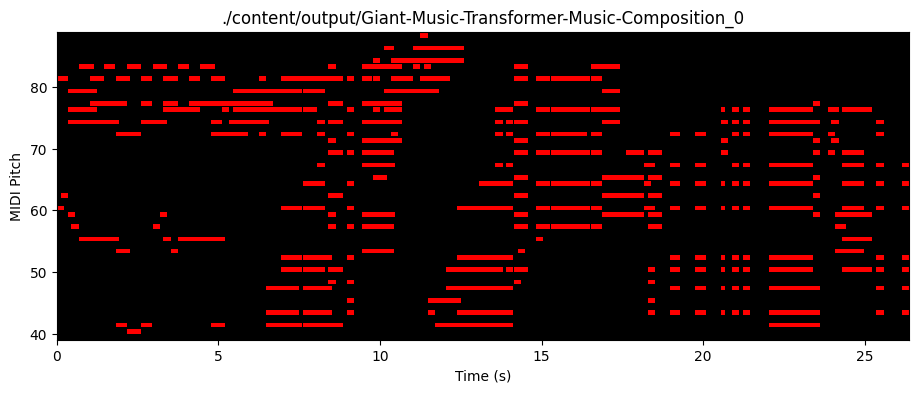

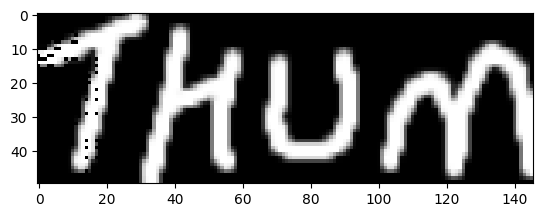

In [ ]:
#@title Standard Continuation Generator

#@markdown Generation settings

try_to_generate_outro = False #@param {type:"boolean"}
try_to_introduce_drums = False # @param {type:"boolean"}
number_of_tokens_to_generate = 1560 # @param {type:"slider", min:33, max:1024, step:3}
number_of_batches_to_generate = 1 #@param {type:"slider", min:1, max:16, step:1}
preview_length_in_tokens = 120 # @param {type:"slider", min:33, max:240, step:3}
number_of_memory_tokens = 7203 # @param {type:"slider", min:300, max:8190, step:3}
temperature = 1 # @param {type:"slider", min:0.1, max:1, step:0.05}
model_sampling_top_p_value = 0.96 # @param {type:"slider", min:0.1, max:1, step:0.01}

#@markdown Other settings

allow_model_to_stop_generation_if_needed = False #@param {type:"boolean"}
render_MIDI_to_audio = True # @param {type:"boolean"}

img = cv2.imread('./Seeds/pics/5.png')


out, outimg = generate_with_img(
    model = model,
    melody_chords_f = melody_chords_f,
    img = img,
    ctx=ctx,
    number_of_tokens_to_generate = number_of_tokens_to_generate,
    number_of_batches_to_generate = number_of_batches_to_generate,
    number_of_memory_tokens = number_of_memory_tokens,
    temperature = temperature,
    model_sampling_top_p_value = model_sampling_top_p_value,
    try_to_generate_outro = try_to_generate_outro,
    try_to_introduce_drums = try_to_introduce_drums,
    allow_model_to_stop_generation_if_needed = allow_model_to_stop_generation_if_needed,
    )
    


out0 = out.tolist()
# print(f"shape of out: {out.shape}")


torch.cuda.empty_cache()


for i in range(number_of_batches_to_generate):

  print('=' * 70)
  print('Batch #', i)
  print('=' * 70)

  out1 = trim_to_chord(out0[i],
                       enabled=trim_all_outputs_to_last_chord)


  if len(out) != 0:

      preview = melody_chords_f[:preview_length_in_tokens]
      song = preview + out1
      song_f, patches = melody_chords2song_f(song)

      patches = [0 if x==-1 else x for x in patches]
      
      detailed_stats = TMIDIX.Tegridy_ms_SONG_to_MIDI_Converter(song_f,
                                                    output_signature = 'Giant Music Transformer',
                                                    output_file_name = './content/output/Giant-Music-Transformer-Music-Composition_'+str(i),
                                                    track_name='Project Los Angeles',
                                                    list_of_MIDI_patches=patches
                                                    )


      fname = './content/output/Giant-Music-Transformer-Music-Composition_'+str(i)

      if render_MIDI_to_audio:
        midi_audio = midi_to_colab_audio(fname + '.mid')
        display(Audio(midi_audio, rate=16000, normalize=False))

      TMIDIX.plot_ms_SONG(song_f,
                          plot_title=fname,
                          preview_length_in_notes=0
                          )
      # plot image
      outimg = cv2.flip(outimg, 0)
      plt.imshow(outimg, cmap="gray")
      plt.show()

img.shape: (50, 178)
prompts shape: torch.Size([1, 216])
img shape: (50, 178)
Generating sequence of max length: 1560
sl: 0
img_px: 0 img_py: 32 ntime: 0 ndur: 0 npit: 108
in branch 4
0 / 1560
sl: 1
img_px: 0 img_py: 32 ntime: 0 ndur: 0 npit: 108
in branch 5
sl: 2
img_px: 0 img_py: 32 ntime: 0 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([32], device='cuda:0') 0 0
sl: 3
img_px: 1 img_py: 33 ntime: 0 ndur: 224 npit: 32
in branch 2
sl: 4
img_px: 1 img_py: 33 ntime: 336 ndur: 224 npit: 108
in branch 5
sl: 5
img_px: 1 img_py: 33 ntime: 336 ndur: 1360 npit: 108
in branch 6
drawing in img at: tensor([34], device='cuda:0') 1 6
sl: 6
img_px: 1 img_py: 30 ntime: 336 ndur: 1360 npit: 34
in branch 4
sl: 7
img_px: 1 img_py: 30 ntime: 336 ndur: 1360 npit: 34
in branch 5
sl: 8
img_px: 1 img_py: 30 ntime: 336 ndur: 224 npit: 34
in branch 6
drawing in img at: tensor([31], device='cuda:0') 1 2
sl: 9
img_px: 2 img_py: 31 ntime: 336 ndur: 224 npit: 31
in branch 2
sl: 10
img_px: 2 img_py: 31 

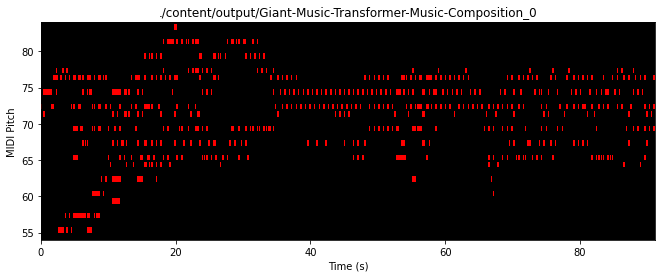

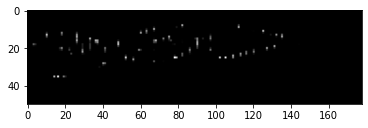

img.shape: (50, 178)
prompts shape: torch.Size([1, 1560])
img shape: (50, 178)
Generating sequence of max length: 1560
sl: 0
img_px: 0 img_py: 27 ntime: 0 ndur: 0 npit: 108
in branch 4
0 / 1560
sl: 1
img_px: 0 img_py: 27 ntime: 0 ndur: 0 npit: 108
in branch 5
sl: 2
img_px: 0 img_py: 27 ntime: 0 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([27], device='cuda:0') 0 0
sl: 3
img_px: 1 img_py: 28 ntime: 0 ndur: 224 npit: 27
in branch 2
sl: 4
img_px: 1 img_py: 28 ntime: 336 ndur: 224 npit: 108
in branch 5
sl: 5
img_px: 1 img_py: 28 ntime: 336 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([29], device='cuda:0') 1 2
sl: 6
img_px: 2 img_py: 28 ntime: 336 ndur: 224 npit: 29
in branch 2
sl: 7
img_px: 2 img_py: 28 ntime: 688 ndur: 224 npit: 108
in branch 5
sl: 8
img_px: 2 img_py: 28 ntime: 688 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([29], device='cuda:0') 2 3
sl: 9
img_px: 3 img_py: 29 ntime: 688 ndur: 224 npit: 29
in branch 2
sl: 10
img_px: 3 img_py: 29 

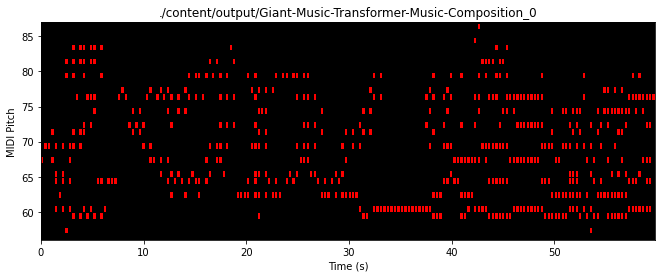

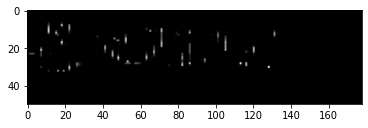

img.shape: (50, 178)
prompts shape: torch.Size([1, 1560])
img shape: (50, 178)
Generating sequence of max length: 1560
sl: 0
img_px: 0 img_py: 32 ntime: 0 ndur: 0 npit: 108
in branch 4
0 / 1560
sl: 1
img_px: 0 img_py: 32 ntime: 0 ndur: 0 npit: 108
in branch 5
sl: 2
img_px: 0 img_py: 32 ntime: 0 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([32], device='cuda:0') 0 0
sl: 3
img_px: 0 img_py: 29 ntime: 0 ndur: 224 npit: 32
in branch 4
sl: 4
img_px: 0 img_py: 29 ntime: 0 ndur: 224 npit: 32
in branch 5
sl: 5
img_px: 0 img_py: 29 ntime: 0 ndur: 224 npit: 32
in branch 6
drawing in img at: tensor([29], device='cuda:0') 0 0
sl: 6
img_px: 0 img_py: 26 ntime: 0 ndur: 224 npit: 29
in branch 4
sl: 7
img_px: 0 img_py: 26 ntime: 0 ndur: 224 npit: 29
in branch 5
sl: 8
img_px: 0 img_py: 26 ntime: 0 ndur: 224 npit: 29
in branch 6
drawing in img at: tensor([27], device='cuda:0') 0 0
sl: 9
img_px: 0 img_py: 23 ntime: 0 ndur: 224 npit: 27
in branch 4
sl: 10
img_px: 0 img_py: 23 ntime: 0 ndur: 2

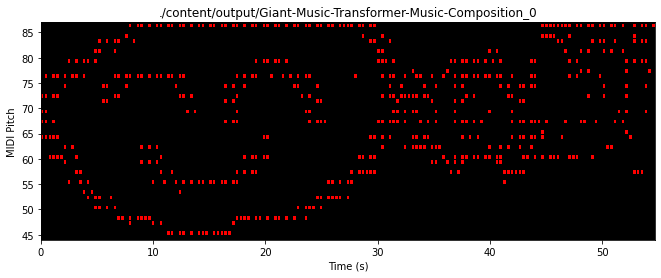

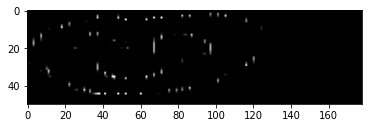

img.shape: (50, 178)
prompts shape: torch.Size([1, 1560])
img shape: (50, 178)
Generating sequence of max length: 1560
sl: 0
img_px: 7 img_py: 33 ntime: 0 ndur: 0 npit: 108
in branch 2
0 / 1560
sl: 1
img_px: 7 img_py: 33 ntime: 336 ndur: 0 npit: 108
sl: 2
img_px: 7 img_py: 33 ntime: 336 ndur: 224 npit: 108
drawing in img at: tensor([44], device='cuda:0') 1 2
sl: 3
img_px: 7 img_py: 33 ntime: 336 ndur: 224 npit: 44
in branch 2
sl: 4
img_px: 7 img_py: 33 ntime: 688 ndur: 224 npit: 108
sl: 5
img_px: 7 img_py: 33 ntime: 688 ndur: 224 npit: 108
drawing in img at: tensor([41], device='cuda:0') 2 3
sl: 6
img_px: 7 img_py: 33 ntime: 688 ndur: 224 npit: 41
in branch 2
sl: 7
img_px: 7 img_py: 33 ntime: 1024 ndur: 224 npit: 108
sl: 8
img_px: 7 img_py: 33 ntime: 1024 ndur: 224 npit: 108
drawing in img at: tensor([44], device='cuda:0') 4 4
sl: 9
img_px: 7 img_py: 33 ntime: 1024 ndur: 224 npit: 44
in branch 2
sl: 10
img_px: 7 img_py: 33 ntime: 1360 ndur: 224 npit: 108
sl: 11
img_px: 7 img_py: 33 nti

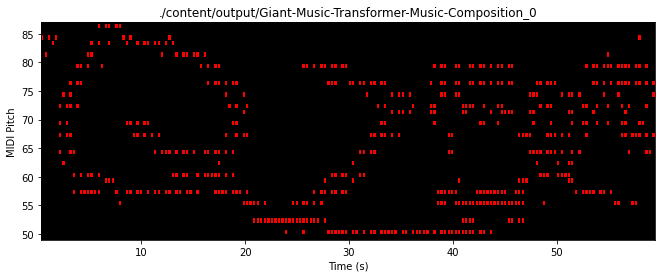

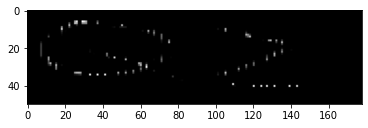

img.shape: (50, 178)
prompts shape: torch.Size([1, 1560])
img shape: (50, 178)
Generating sequence of max length: 1560
sl: 0
img_px: 9 img_py: 35 ntime: 0 ndur: 0 npit: 108
in branch 2
0 / 1560
sl: 1
img_px: 9 img_py: 35 ntime: 352 ndur: 0 npit: 108
sl: 2
img_px: 9 img_py: 35 ntime: 352 ndur: 224 npit: 108
drawing in img at: tensor([36], device='cuda:0') 1 2
sl: 3
img_px: 9 img_py: 35 ntime: 352 ndur: 224 npit: 36
in branch 2
sl: 4
img_px: 9 img_py: 35 ntime: 688 ndur: 224 npit: 108
sl: 5
img_px: 9 img_py: 35 ntime: 688 ndur: 224 npit: 108
drawing in img at: tensor([39], device='cuda:0') 2 3
sl: 6
img_px: 9 img_py: 35 ntime: 688 ndur: 224 npit: 39
in branch 2
sl: 7
img_px: 9 img_py: 35 ntime: 1024 ndur: 224 npit: 108
sl: 8
img_px: 9 img_py: 35 ntime: 1024 ndur: 224 npit: 108
drawing in img at: tensor([39], device='cuda:0') 4 4
sl: 9
img_px: 9 img_py: 35 ntime: 1024 ndur: 224 npit: 39
in branch 2
sl: 10
img_px: 9 img_py: 35 ntime: 1536 ndur: 224 npit: 108
sl: 11
img_px: 9 img_py: 35 nti

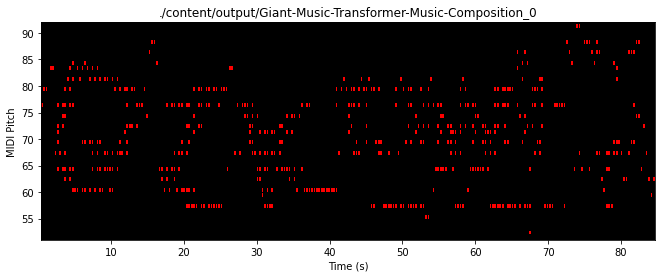

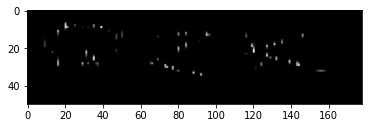

img.shape: (50, 178)
prompts shape: torch.Size([1, 1560])
img shape: (50, 178)
Generating sequence of max length: 1560
sl: 0
img_px: 0 img_py: 27 ntime: 0 ndur: 0 npit: 108
in branch 4
0 / 1560
sl: 1
img_px: 0 img_py: 27 ntime: 0 ndur: 0 npit: 108
in branch 5
sl: 2
img_px: 0 img_py: 27 ntime: 0 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([27], device='cuda:0') 0 0
sl: 3
img_px: 0 img_py: 24 ntime: 0 ndur: 224 npit: 27
in branch 4
sl: 4
img_px: 0 img_py: 24 ntime: 0 ndur: 224 npit: 27
in branch 5
sl: 5
img_px: 0 img_py: 24 ntime: 0 ndur: 224 npit: 27
in branch 6
drawing in img at: tensor([24], device='cuda:0') 0 0
sl: 6
img_px: 0 img_py: 21 ntime: 0 ndur: 224 npit: 24
in branch 4
sl: 7
img_px: 0 img_py: 21 ntime: 0 ndur: 224 npit: 24
in branch 5
sl: 8
img_px: 0 img_py: 21 ntime: 0 ndur: 224 npit: 24
in branch 6
drawing in img at: tensor([20], device='cuda:0') 0 0
sl: 9
img_px: 1 img_py: 28 ntime: 0 ndur: 224 npit: 20
in branch 2
sl: 10
img_px: 1 img_py: 28 ntime: 336 ndur:

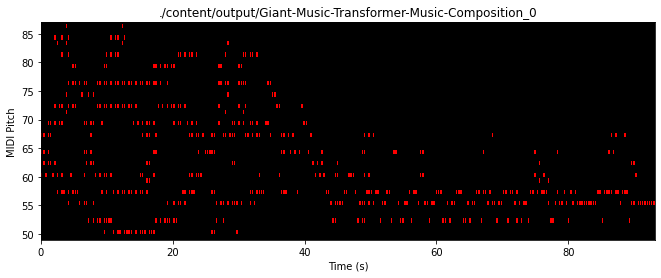

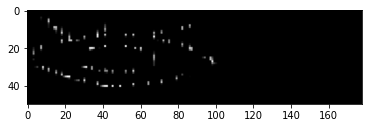

img.shape: (50, 178)
prompts shape: torch.Size([1, 1560])
img shape: (50, 178)
Generating sequence of max length: 1560
sl: 0
img_px: 0 img_py: 21 ntime: 0 ndur: 0 npit: 108
in branch 4
0 / 1560
sl: 1
img_px: 0 img_py: 21 ntime: 0 ndur: 0 npit: 108
in branch 5
sl: 2
img_px: 0 img_py: 21 ntime: 0 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([22], device='cuda:0') 0 0
sl: 3
img_px: 1 img_py: 22 ntime: 0 ndur: 224 npit: 22
in branch 2
sl: 4
img_px: 1 img_py: 22 ntime: 336 ndur: 224 npit: 108
in branch 5
sl: 5
img_px: 1 img_py: 22 ntime: 336 ndur: 224 npit: 108
in branch 6
drawing in img at: tensor([22], device='cuda:0') 1 2
sl: 6
img_px: 1 img_py: 19 ntime: 336 ndur: 224 npit: 22
in branch 4
sl: 7
img_px: 1 img_py: 19 ntime: 336 ndur: 224 npit: 22
in branch 5
sl: 8
img_px: 1 img_py: 19 ntime: 336 ndur: 224 npit: 22
in branch 6
drawing in img at: tensor([20], device='cuda:0') 1 2
sl: 9
img_px: 2 img_py: 19 ntime: 336 ndur: 224 npit: 20
in branch 2
sl: 10
img_px: 2 img_py: 19 nt

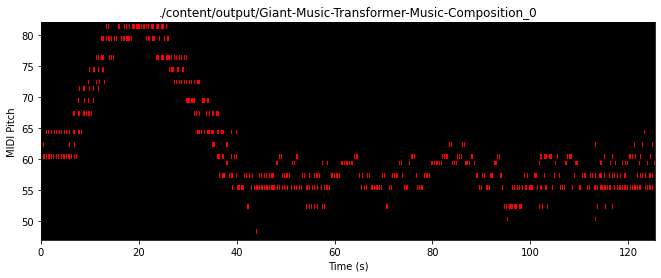

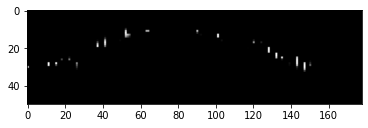

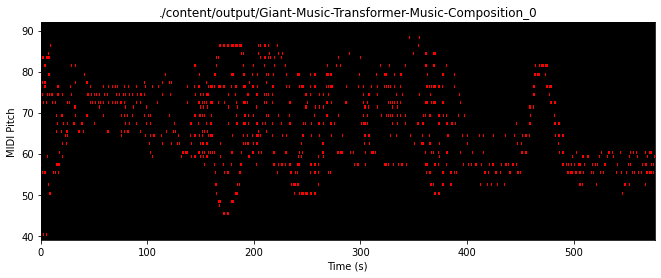

In [11]:
imgs_root_path = './Seeds/pics/'
imgs_path = os.listdir(imgs_root_path)
imgs_path = [os.path.join(imgs_root_path, img) for img in imgs_path if img.endswith('.png')]

prompt_imgs = []
for img_path in imgs_path:
    img = cv2.imread(img_path)
    prompt_imgs.append(img)


full_music = melody_chords_f


for img in prompt_imgs:
    out, outimg = generate_with_img(
        model = model,
        melody_chords_f = melody_chords_f,
        img = img,
        ctx=ctx,
        number_of_tokens_to_generate = number_of_tokens_to_generate,
        number_of_batches_to_generate = number_of_batches_to_generate,
        number_of_memory_tokens = number_of_memory_tokens,
        temperature = temperature,
        model_sampling_top_p_value = model_sampling_top_p_value,
        try_to_generate_outro = try_to_generate_outro,
        try_to_introduce_drums = try_to_introduce_drums,
        allow_model_to_stop_generation_if_needed = allow_model_to_stop_generation_if_needed,
        )
    out0 = out.tolist()
    melody_chords_f = out0[0]
    melody_chords_f = trim_to_chord(melody_chords_f,
                                    enabled=trim_all_outputs_to_last_chord)
    
    full_music = full_music + melody_chords_f[-number_of_tokens_to_generate:]


    song_f, patches = melody_chords2song_f(melody_chords_f)

    patches = [0 if x==-1 else x for x in patches]


    TMIDIX.plot_ms_SONG(song_f,
                        plot_title=fname,
                        preview_length_in_notes=0
                        )
    # plot image
    outimg = cv2.flip(outimg, 0)
    plt.imshow(outimg, cmap="gray")
    plt.show()
    

full_music_songf, patches = melody_chords2song_f(full_music)

TMIDIX.plot_ms_SONG(full_music_songf,
                    plot_title=fname,
                    preview_length_in_notes=0
                    )

In [ ]:
full_music_midi = TMIDIX.opus2midi(full_music_songf)
fname = './content/output/Giant-Music-Transformer-Full-Music-Composition/full_music'
detailed_stats = TMIDIX.Tegridy_ms_SONG_to_MIDI_Converter(full_music_songf,
                                                    output_signature = 'Giant Music Transformer',
                                                    output_file_name = './content/output/full',
                                                    track_name='Project Los Angeles',
                                                    list_of_MIDI_patches=patches
                                                    )

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'